In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
folder = r'C:\Users\AXW0J9E\Downloads\SMAP\TranAD\Andre'

In [3]:
def normalize3(a, min_a = None, max_a = None):
	if min_a is None: min_a, max_a = np.min(a, axis = 0), np.max(a, axis = 0)
	return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

In [4]:
def get_data(dataset):
    dataset_folder = r'C:\Users\Andre\Downloads\SMAP\TranAD\data\SMAP_MSL' #Be sure to change the directory
    file = os.path.join(dataset_folder, 'labeled_anomalies.csv')
    values = pd.read_csv(file)
    values = values[values['spacecraft'] == dataset]
    filenames = values['chan_id'].values.tolist()
    for fn in filenames:
        train = np.load(f'{dataset_folder}/train/{fn}.npy')
        test = np.load(f'{dataset_folder}/test/{fn}.npy')
        train, min_a, max_a = normalize3(train)
        test, _, _ = normalize3(test, min_a, max_a)
        train_df = pd.DataFrame(train)
        test_df = pd.DataFrame(test)
        train_df.to_csv(f'{folder}/{fn}_train.csv')
        test_df.to_csv(f'{folder}/{fn}_test.csv')
        labels = np.zeros(test.shape)
        indices = values[values['chan_id'] == fn]['anomaly_sequences'].values[0]
        indices = indices.replace(']', '').replace('[', '').split(', ')
        indices = [int(i) for i in indices]
        for i in range(0, len(indices), 2):
            labels[indices[i]:indices[i+1], :] = 1
        labels = pd.DataFrame(labels)
        labels.to_csv(f'{folder}/{fn}_labels.csv')

In [5]:
get_data('SMAP')

In [6]:
test = pd.read_csv(f'{folder}/P-1_test.csv').drop(columns='Unnamed: 0')
train = pd.read_csv(f'{folder}/P-1_train.csv').drop(columns='Unnamed: 0')
labels = pd.read_csv(f'{folder}/P-1_labels.csv').drop(columns='Unnamed: 0')

In [7]:
test.columns = ['feature' + str(col) for col in test.columns]

In [8]:
labels.columns = ['label' + str(col) for col in labels.columns]

In [9]:
labels

,label0,label1,label2,label3,label4,label5,label6,label7,label8,label9,...,label15,label16,label17,label18,label19,label20,label21,label22,label23,label24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
labels['anomalies'] = labels.max(axis=1)


In [11]:
labels['anomalies'].value_counts()

anomalies
0.0    7757
1.0     748
Name: count, dtype: int64

In [12]:
import numpy as np

sequence_length = 10
num_features = 25

data = train.values  # Assuming df is your DataFrame
sequences = []

for i in range(len(data) - sequence_length + 1):
    sequences.append(data[i:i+sequence_length])

sequences = np.array(sequences)  # This will have shape (num_sequences, sequence_length, num_features)

In [13]:
# Split the original training set into a new training set and a validation set
train_size = int(0.8 * len(sequences))
x_val = sequences[train_size:]
x_train = sequences[:train_size]


In [14]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, reg_factor, bottleneck_dim, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.attention1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense1 = layers.Dense(embed_dim, activation="relu", kernel_regularizer=regularizers.l2(reg_factor))
        self.attention2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense2 = layers.Dense(int(embed_dim/2), activation="relu", kernel_regularizer=regularizers.l2(reg_factor))
        self.bottleneck = layers.Dense(bottleneck_dim, activation="relu")

    def call(self, inputs):
        attn_output1 = self.attention1(inputs, inputs)
        output = self.dense1(attn_output1)
        attn_output2 = self.attention2(output, output)
        output = self.dense2(attn_output2)
        bottleneck_output = self.bottleneck(output)
        return bottleneck_output

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, reg_factor, bottleneck_dim, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dense1 = layers.Dense(int(embed_dim/2), activation="relu", kernel_regularizer=regularizers.l2(reg_factor))
        self.attention1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense2 = layers.Dense(embed_dim, activation="relu", kernel_regularizer=regularizers.l2(reg_factor))
        self.attention2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.reconstruction = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs):
        output = self.dense1(inputs)
        attn_output1 = self.attention1(output, output)
        output = self.dense2(attn_output1)
        attn_output2 = self.attention2(output, output)
        reconstruction = self.reconstruction(attn_output2)
        return reconstruction

class TransformerAutoEncoder(tf.keras.Model):
    def __init__(self, embed_dim, num_heads, reg_factor, bottleneck_dim,**kwargs):
        super(TransformerAutoEncoder, self).__init__(**kwargs)
        self.encoder = TransformerEncoder(embed_dim, num_heads, reg_factor,bottleneck_dim)
        self.decoder = TransformerDecoder(embed_dim, num_heads, reg_factor,bottleneck_dim)

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded


In [15]:
embed_dim = 25  # This should match the number of features in your multivariate time series
num_heads = 8  # This is a hyperparameter you can tune
bottleneck_dim = 10
reg_factor = 0.01  # You should tune this hyperparameter
model = TransformerAutoEncoder(embed_dim, num_heads, reg_factor,bottleneck_dim)

learning_rate = 0.0001  # You can adjust this value
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mae')




In [16]:
# Now we have x_train, x_val and x_test
history = model.fit(x_train, x_train, epochs=100, validation_data=(x_val, x_val))


Epoch 1/100
72/72 [==============================] - 7s 20ms/step - loss: 0.6963 - val_loss: 0.6772
Epoch 2/100
72/72 [==============================] - 1s 15ms/step - loss: 0.6559 - val_loss: 0.6402
Epoch 3/100
72/72 [==============================] - 1s 16ms/step - loss: 0.6212 - val_loss: 0.6070
Epoch 4/100
72/72 [==============================] - 1s 16ms/step - loss: 0.5889 - val_loss: 0.5755
Epoch 5/100
72/72 [==============================] - 1s 18ms/step - loss: 0.5583 - val_loss: 0.5456
Epoch 6/100
72/72 [==============================] - 2s 27ms/step - loss: 0.5292 - val_loss: 0.5173
Epoch 7/100
72/72 [==============================] - 2s 26ms/step - loss: 0.5016 - val_loss: 0.4904
Epoch 8/100
72/72 [==============================] - 2s 30ms/step - loss: 0.4753 - val_loss: 0.4647
Epoch 9/100
72/72 [==============================] - 2s 28ms/step - loss: 0.4500 - val_loss: 0.4403
Epoch 10/100
72/72 [==============================] - 2s 28ms/step - loss: 0.4262 - val_loss: 0.4172

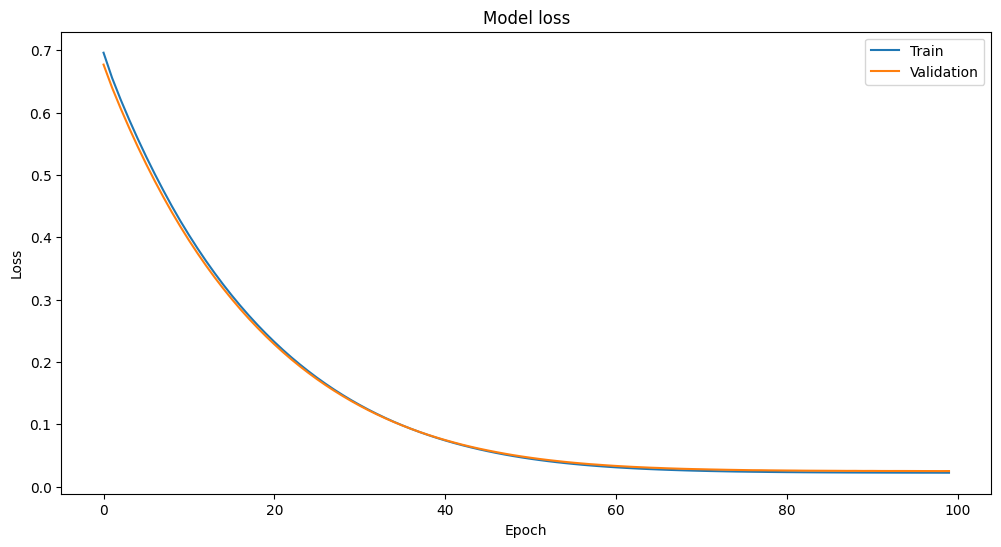

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [18]:
test

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24
0,0.152411,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0
1,0.157140,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0
2,0.137134,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0
3,0.119310,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0
4,0.127313,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8500,0.646748,0.0,0.0,0.0,0.0,0.9999,0.9999,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0
8501,0.670756,0.0,0.0,0.0,0.0,0.9999,0.9999,0.0,0.0,0.0,...,0.0,0.0,0.9999,0.9999,0.0,0.0,0.9999,0.9999,0.0,0.0
8502,0.341925,0.0,0.0,0.0,0.0,0.9999,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0
8503,0.351383,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0


In [19]:
import numpy as np

sequence_length = 10
num_features = 25

data = test.values  # Assuming df is your DataFrame
sequences = []

for i in range(len(data) - sequence_length + 1):
    sequences.append(data[i:i+sequence_length])

sequences = np.array(sequences)  # This will have shape (num_sequences, sequence_length, num_features)

In [20]:
# Assume x_test is your new data
predictions = model.predict(sequences)


266/266 [==============================] - 5s 15ms/step


In [21]:
errors = np.mean(np.abs(predictions - sequences), axis=(1,2))

In [22]:
threshold = np.percentile(errors, 95)  # use 95th percentile as the threshold

In [23]:
#threshold = np.mean(errors) + 1 * np.std(errors)  # three standard deviations away from the mean

In [24]:
anomalies = np.where(errors > threshold, 1, 0)

In [25]:
predicted_labels = pd.DataFrame(anomalies)
true_labels = pd.DataFrame(labels['anomalies'])

In [26]:
df = pd.concat([predicted_labels,true_labels],axis=1)
df.rename(columns={0:'predicted_labels','anomalies':'true_labels'},inplace=True)
shifted_value = true_labels.shape[0] - predicted_labels.shape[0]
df['predicted_labels'] = df['predicted_labels'].shift(shifted_value)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Assuming df is your DataFrame and 'predicted_labels' and 'true_labels' are your column names
y_pred = df['predicted_labels']
y_true = df['true_labels']

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate confusion matrix
confusion = confusion_matrix(y_true, y_pred)
print(f'Confusion Matrix:\n {confusion}')

# Calculate f1 score
f1 = f1_score(y_true, y_pred)
print(f'F1 Score: {f1}')


Accuracy: 0.871822033898305
Confusion Matrix:
 [[7365  383]
 [ 706   42]]
F1 Score: 0.07161125319693094


In [29]:
df[df['true_labels']==1].head(30)

,predicted_labels,true_labels
2140,0.0,1.0
2141,0.0,1.0
2142,0.0,1.0
2143,0.0,1.0
2144,0.0,1.0
2145,0.0,1.0
2146,0.0,1.0
2147,0.0,1.0
2148,0.0,1.0
2149,0.0,1.0
